### Imports

In [1]:
from datetime import datetime

import pandas as pd
import numpy as np

import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier, plot_importance

### Reading csv files

* Files located in data/ directory:
    * PPK_Participants.csv
    * PPK_Employers.csv
* After reading files we merge them into one dataframe, adding columns describing participant's employer data

In [2]:
# Reading CSV files
participants = pd.read_csv('data/PPK_Participants.csv', sep=';')
employers = pd.read_csv('data/PPK_Employers.csv', sep=';')

# Merging
df = pd.merge(
    participants,
    employers,
    how='left',
    left_on='EMPL_ID',
    right_on='ID'
)


### Processing features, cleaning up unimportant information

* Droppping useless or close to useless columns 

* Fixing the `AGE` column because of its weird format

* Containing small nationality groups into one 'other' nationality group

* Converting categorical data into boolean dummy variables

* Finding `DURATION` - days since participant registered for the program

In [3]:
# Dropping useless columns providing no information
df.drop(columns=['MEMBER_ID',
                 'EMPL_ID',  
                 'LOGICAL_FACTOR_1',
                 'LOGICAL_FACTOR_2',
                 'ID',
                 'PKD_CODE',
                 'NUMERICAL_VALUE'], inplace = True)

# These features are of dubious utility, weakly correlated with the label column, providing little to no information
df.drop(columns =["CREATED_AT", 
                  "UOZ_START_DATE", 
                  "UOP_SIGN_DATE", 
                  'REGION_CODE',
                  'PPK_BANK',
                  'WORK_START', 
                  'WORK_STOP'], inplace = True)

# The contest committee ruled out not to use this feature as it should not be included in final test dataset
df.drop(columns = ["RESIGN_DATE"], inplace = True)

In [4]:
# Age to int
def to_int(age):
    age = age[:age.find(",")]
    return int(age)

df["AGE"] = df["AGE"].apply(to_int)

In [5]:
# Grouping other nationalities into one category '0'

unique_nat = df['NATIONALITY'].unique()
for val in unique_nat:
    suma = ( df['NATIONALITY'].values == val ).sum()
    if suma < 5000:
        df.loc[df.NATIONALITY == val, 'NATIONALITY'] = 0       

In [6]:
# Converting categorical data into boolean dummy variables
df = pd.get_dummies(df, columns = ['SEX', 'COMPANY_SIZE', 'COMPANY_TYPE', 'VOIVODESHIP', 'NATIONALITY','PPK_STAGE'], 
                         prefix = ['SEX', 'COMPANY_SIZE', 'COMPANY_TYPE', 'VOIVODESHIP', 'NATIONALITY','PPK_STAGE'])

In [7]:
# duration - time since signing up
def find_period(start):
    stop = datetime.now().strftime("%Y-%m-%d")
    
    start_year, start_month, start_day = map(int, start.split('-'))
    stop_year, stop_month, stop_day = map(int, stop.split('-'))
    
    days = (stop_year - start_year)*365
    days += (stop_month - start_month)*30 if stop_month > start_month else (start_month - stop_month)*30
    days += stop_day - start_day if stop_day > start_day else start_day - stop_day
    
    return days

df['DURATION'] = df['SIGN_DATE'].apply(find_period) 
df.drop(columns = ['SIGN_DATE'], inplace = True)

### What the dataframe looks like

In [8]:
df

,IS_SUSPENDED,AGE,HAS_AE,HAS_AW,HAS_IP,SEX_K,SEX_M,SEX_N,COMPANY_SIZE_A,COMPANY_SIZE_B,...,VOIVODESHIP_ŚWIĘTOKRZYSKIE,NATIONALITY_0,NATIONALITY_114,NATIONALITY_136,NATIONALITY_187,PPK_STAGE_1,PPK_STAGE_2,PPK_STAGE_3,PPK_STAGE_4,DURATION
0,0,62,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,523
1,0,85,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,428
2,0,82,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,428
3,0,67,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,428
4,0,91,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1793206,1,63,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,1,0,374
1793207,1,45,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,1,0,374
1793208,1,86,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,1,0,374
1793209,1,49,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,1,0,374


### Train/test data split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df[df.columns[1:]], 
                                                    df["IS_SUSPENDED"], 
                                                    stratify=df["IS_SUSPENDED"], 
                                                    test_size=0.10, 
                                                    random_state=56)

## Gradient Boosting

Classes are unbalanced, so we need to scale up the positive class.

In [10]:
pos = df["IS_SUSPENDED"].sum()/len(df)
scalar = (1-pos)/pos

#### Training

In [11]:
XGB = XGBClassifier(max_depth=5, 
                  learning_rate=0.1, 
                  objective= 'binary:logistic',
                  n_jobs=-1,
                  use_label_encoder = False,
                  scale_pos_weight = scalar,
                  verbosity=0)
                                
    
xgb_model = XGB.fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.82
Accuracy of XGB classifier on test set: 0.82


In [12]:
y_pred = xgb_model.predict(X_test)

#### Classification report

In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.84      0.89    148055
           1       0.49      0.71      0.58     31267

    accuracy                           0.82    179322
   macro avg       0.71      0.78      0.73    179322
weighted avg       0.86      0.82      0.83    179322



#### Feature importance chart

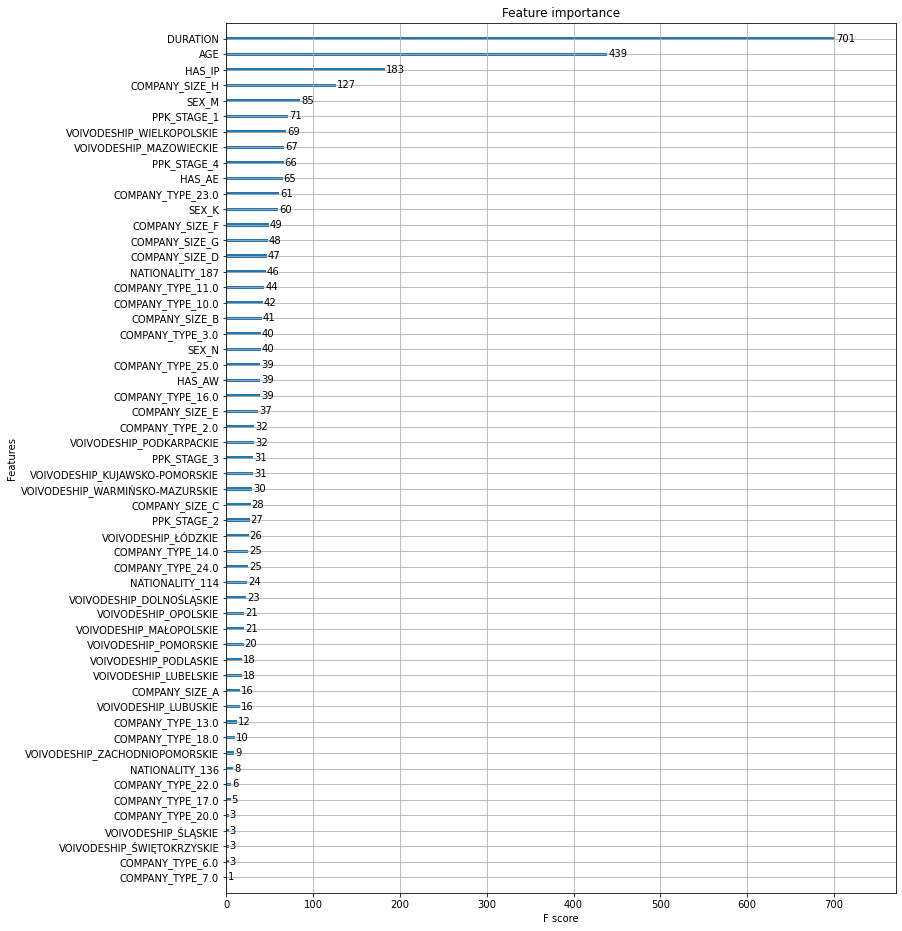

In [14]:
fig, ax = plt.subplots(figsize=(12,16))
plot_importance(xgb_model, ax=ax)